<center><h1>Modelling</h1></center> <br>
The purpose of this notebook is to utilize the merged seasons data from <a href='https://github.com/vaastav/Fantasy-Premier-League/'>vaastav's public github repository</a> which regularly accesses and updates from the FPL API storing the data in csv files.

We will begin by merging the gameweek-by-gameweek data from previous season to the last season (2022-23). Once this is completed, we will engineer features that may be beneficial to predicting the points earned in a gameweek. We will then move on to comparing different types of regression models with hyperparameter tuning and selecting the model with the best RMSE score.

RMSE is the average difference between predicted values and actual values, we will be attempting to optimize for a low RMSE score.

Below is a breakdown of the steps to be taken:

1. [Data Merging and Feature Selection](#dmfs)<br><br>
2. [Feature Engineering and Noise Reduction](#fenr) <br><br>
3. [Feature Correlation Map](#fcm)<br><br>
4. [Modelling](#m) <br>
    a. [Linear Regression](#lr) <br>
    b. [Lasso Regression](#lasso) <br>
    c. [Ridge Regression](#ridge) <br>
    d. [Random Forest Regressor](#rfr) <br>
    e. [XGB Regressor](#xgb) <br><br>
5. [Model Comparison](#mc) <br>
6. [Future Considerations and Exporting](#fc)<br>

<a id="dmfs"><h1>Data Merging and Feature Selection</h1></a>

In this section we will import the necessary libraries and reading in the previous season data (2016-17 to 2021-22). We will be taking a look at the data and seeing if there is any data cleaning that may be required and then selecting features for modelling. 

We will repeat this process with the previous season (2022-23) and merge this to create a combined dataframe containing all historical data.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)
cleaned_seasons.info()

C:\Users\Farhan Kassam\AppData\Local\Temp\ipykernel_2700\1541133532.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           98402 non-null  object 
 1   name               98402 non-null  object 
 2   position           98402 non-null  object 
 3   team_x             48930 non-null  object 
 4   assists            98402 non-null  int64  
 5   bonus              98402 non-null  int64  
 6   bps                98402 non-null  int64  
 7   clean_sheets       98402 non-null  int64  
 8   creativity         98402 non-null  float64
 9   element            98402 non-null  int64  
 10  fixture            98402 non-null  int64  
 11  goals_conceded     98402 non-null  int64  
 12  goals_scored       98402 non-null  int64  
 13  ict_index          98402 non-null  float64
 14  influence          98402 non-null  float64
 15  kickoff_time       98402 non-null  object 
 16  minutes            984

In [2]:
cleaned_seasons.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
# Checking if the empty team name values are from seasons 2016-17 to 2019-20

cleaned_seasons.loc[cleaned_seasons['team_x'].isnull() == True,].equals\
(cleaned_seasons.loc[cleaned_seasons['season_x'] <= '2019-20',])

True

Since I've decided not to include the team of a player as a contributing factor to their FPL score I will not be attempting to fill the null values and continue to reduce the shape of the dataframe for relevant columns. 

Although the team name is significant when picking a team since there cannot be more than 3 players from the same team on a Fantasy team, this is only significant in our testing sets which we will pick from the 22/23 season data.

In [4]:
season_slice = cleaned_seasons[['season_x', 'name', 'team_x', 'position', 'GW', 'value', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'ict_index', 'total_points']].rename(columns={"team_x": "team"})
season_slice.head()

,season_x,name,team,position,GW,value,minutes,goals_scored,assists,clean_sheets,ict_index,total_points
0,2016-17,Aaron Cresswell,NaN,DEF,1,55,0,0,0,0,0.0,0
1,2016-17,Aaron Lennon,NaN,MID,1,60,15,0,0,0,0.9,1
2,2016-17,Aaron Ramsey,NaN,MID,1,80,60,0,0,0,3.0,2
3,2016-17,Abdoulaye Doucouré,NaN,MID,1,50,0,0,0,0,0.0,0
4,2016-17,Adam Forshaw,NaN,MID,1,45,69,0,0,0,0.3,1


In [5]:
last_season = pd.read_csv('../data/merged_gw.csv')
last_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  object 
 1   position                    26505 non-null  object 
 2   team                        26505 non-null  object 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals              26505 non-null  float64
 13  expected_goals_conceded     265

In [6]:
last_season['season_x'] = '2022-23'

In [7]:
subset_last_season = last_season[['season_x', 'name', 'team', 'position', 'GW', 'value', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'ict_index', 'total_points']]
subset_last_season.head()

,season_x,name,team,position,GW,value,minutes,goals_scored,assists,clean_sheets,ict_index,total_points
0,2022-23,Nathan Redmond,Southampton,MID,1,55,1,0,0,0,0.0,1
1,2022-23,Junior Stanislas,Bournemouth,MID,1,50,1,0,0,0,0.0,1
2,2022-23,Armando Broja,Chelsea,FWD,1,55,15,0,0,0,2.5,1
3,2022-23,Fabian Schär,Newcastle,DEF,1,45,90,1,0,1,10.6,15
4,2022-23,Jonny Evans,Leicester,DEF,1,45,90,0,0,0,1.5,1


In [8]:
all_season = pd.concat([season_slice, subset_last_season], ignore_index=True)
all_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   season_x      124907 non-null  object 
 1   name          124907 non-null  object 
 2   team          75435 non-null   object 
 3   position      124907 non-null  object 
 4   GW            124907 non-null  int64  
 5   value         124907 non-null  int64  
 6   minutes       124907 non-null  int64  
 7   goals_scored  124907 non-null  int64  
 8   assists       124907 non-null  int64  
 9   clean_sheets  124907 non-null  int64  
 10  ict_index     124907 non-null  float64
 11  total_points  124907 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 11.4+ MB


<a id="fenr"><h1>Feature Engineering and Noise Reduction</h1></a>

Now we have data from 2016-17 to 2022-23 in our dataframe. Since the ict statistics are populated on a per game basis, we will create a lagged feature for all of our attributes for the previous 5 matches averages as well as rolling sums for all the features.

In [9]:
all_season.columns[6:-1]

Index(['minutes', 'goals_scored', 'assists', 'clean_sheets', 'ict_index'], dtype='object')

In [10]:
to_lag = all_season.columns[6:-1]

for col in to_lag:
    for lag in [5, 'all']:
        lagged = 'last_' + str(lag)+ '_' + col
        if lag == 'all':
            all_season[lagged] = all_season.sort_values('GW').groupby(['name', 'season_x'], group_keys = False)[col].apply(lambda x: x.cumsum() - x)
        else:
            all_season[lagged] = all_season.sort_values('GW').groupby(['name', 'season_x'], group_keys=False)[col].apply(lambda x: (x.rolling(min_periods=1, window=lag+1).sum() - x)/lag)

In [11]:
all_season.head()

,season_x,name,team,position,GW,value,minutes,goals_scored,assists,clean_sheets,ict_index,total_points,last_5_minutes,last_all_minutes,last_5_goals_scored,last_all_goals_scored,last_5_assists,last_all_assists,last_5_clean_sheets,last_all_clean_sheets,last_5_ict_index,last_all_ict_index
0,2016-17,Aaron Cresswell,NaN,DEF,1,55,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
1,2016-17,Aaron Lennon,NaN,MID,1,60,15,0,0,0,0.9,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
2,2016-17,Aaron Ramsey,NaN,MID,1,80,60,0,0,0,3.0,2,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
3,2016-17,Abdoulaye Doucouré,NaN,MID,1,50,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
4,2016-17,Adam Forshaw,NaN,MID,1,45,69,0,0,0,0.3,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0


Since the largest lag is previous 5 matches, the first 5 gameweeks of each season are essentially unknown values for these variables. Additionally, players who do not have any minutes on the field or have less than 60 minutes overall do not earn any points. 

It may be beneficial to remove all of these null rows to reduce noise during modelling.

In [12]:
# data loss from first 5 gameweeks of each season
len(all_season.loc[all_season['GW'] <=5, ]) / len(all_season)

0.11633455290736308

In [13]:
# How much data we lose if we remove all players who did not earn points
len(all_season.loc[all_season['total_points'] == 0,]) / len(all_season)

0.5370635753000232

In [14]:
# checking amount of overlap between first 5 gameweek loss and no points earned loss
(all_season.loc[all_season['GW'] <=5, 'total_points']).eq(all_season.loc[all_season['total_points'] == 0, 'total_points']).sum() / len(all_season)

0.05623383797545374

In [15]:
# How much data will we lose if we remove players who have played less than 60 minutes on average in rolling sum of matches
# and have total points of 0
len(all_season.loc[(all_season['last_all_minutes'] >0) & (all_season['total_points']==0),'total_points']) / len(all_season)

0.2954918459333744

In [16]:
# Checking overlap between no points earned and less than 60 minutes rolling sum and no points earned
(all_season.loc[all_season['total_points'] == 0, 'total_points']).eq(all_season.loc[(all_season['last_all_minutes'] > 0) & (all_season['total_points']==0),'total_points']).sum() / len(all_season) 

0.2954918459333744

Therefore we are losing about 12% of the data due to the lagged variables and 54% of the data from players who did not earn any points due to being benched, injured, receiving negative points etc. There is an approximate of 6% overlap between the lagged variables and players who did not earn points.

I attempted to save some data by only removing players who have not played in the rolling sum of matches and have not earned points, this resulted in a potential loss of 29% of the data which is not much less than the 54% loss of removing all players with no earned points.

To reduce noise in our modelling stage, I will opt to remove the first 5 gameweeks as well as removing rows where players did not play in the rolling sum.

In [17]:
all_season_lagged = all_season.loc[(all_season['GW'] > 5) & (all_season['last_all_minutes'] > 0)].sort_values(['season_x','GW']).reset_index(drop=True)

In [18]:
all_season_lagged = all_season_lagged.drop(to_lag, axis=1)
all_season_lagged.head()

,season_x,name,team,position,GW,value,total_points,last_5_minutes,last_all_minutes,last_5_goals_scored,last_all_goals_scored,last_5_assists,last_all_assists,last_5_clean_sheets,last_all_clean_sheets,last_5_ict_index,last_all_ict_index
0,2016-17,Aaron Lennon,NaN,MID,6,57,0,3.0,15,0.0,0,0.0,0,0.0,0,0.18,0.9
1,2016-17,Aaron Ramsey,NaN,MID,6,77,0,12.0,60,0.0,0,0.0,0,0.0,0,0.60,3.0
2,2016-17,Abdoulaye Doucouré,NaN,MID,6,48,0,1.4,7,0.0,0,0.0,0,0.0,0,0.02,0.1
3,2016-17,Adama Traoré,NaN,MID,6,49,0,2.0,10,0.0,0,0.0,0,0.0,0,0.16,0.8
4,2016-17,Adam Forshaw,NaN,MID,6,45,1,84.4,422,0.0,0,0.0,0,0.2,1,2.54,12.7


<a id= "fcm"> <h1> Feature Correlation Map </h1> </a>

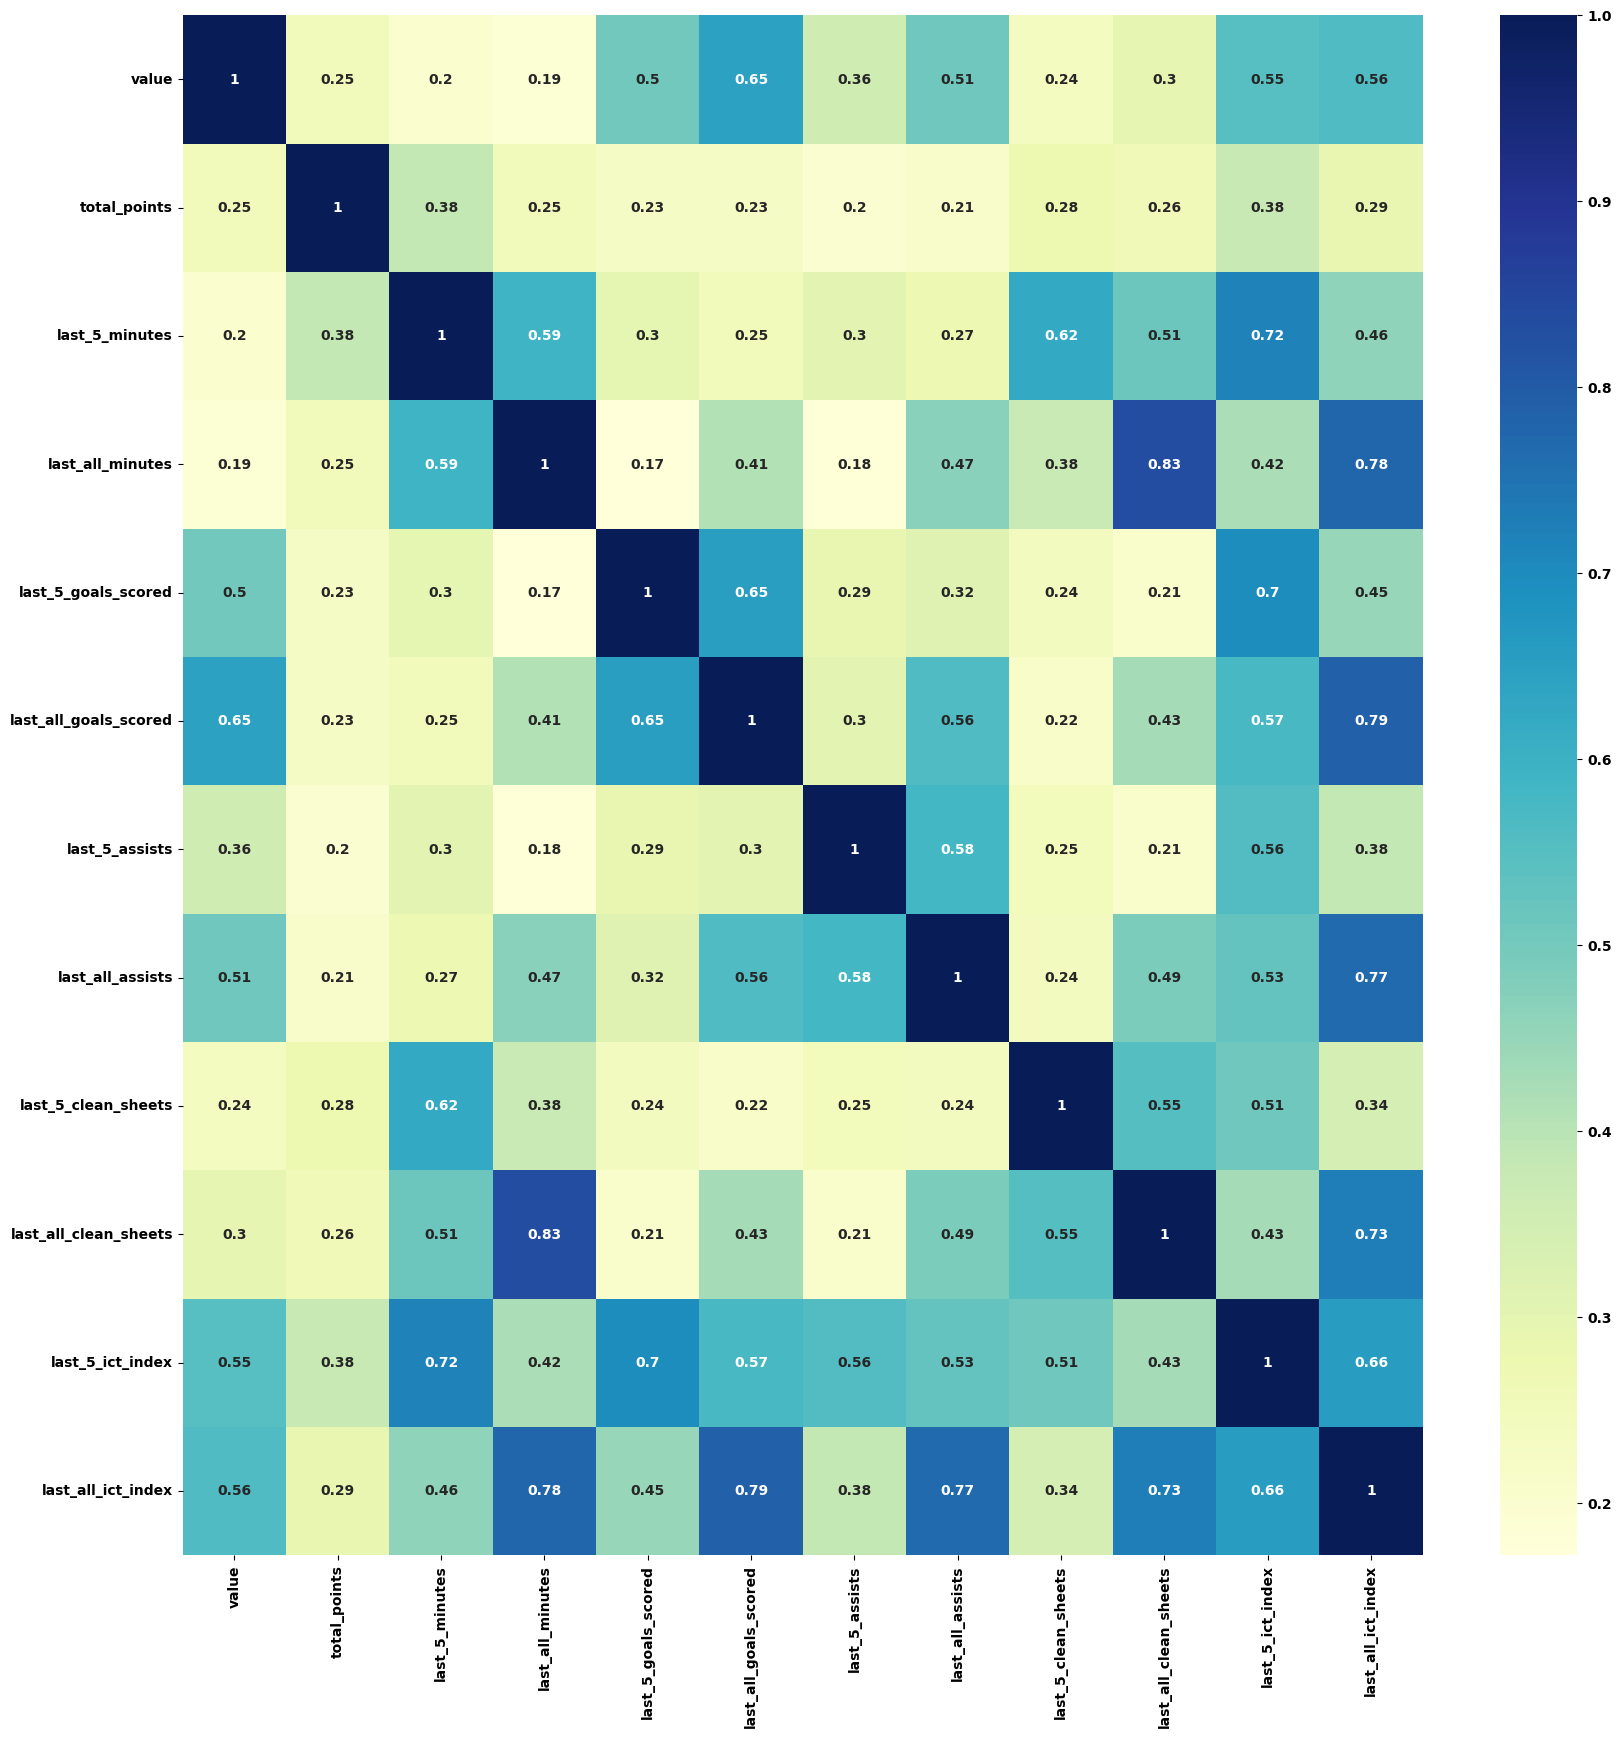

In [19]:
corr = all_season_lagged.iloc[:,5:].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

There is a weak positive correlation between previous 5 matches ict_index and total points earned of 0.38 as well as previous 5 matches minutes. There seems to be a very high correlation between ict_index and minutes played of 0.78 which may introduce some multicollinearity into the model. Additionally, there seems to be some multicollinearity between all features of their rolling tally and last 5 matches results which can be expected since they were engineered from the same data points.

<a id="m"><h1>Modelling</h1></a>

We will begin by encoding the positional data into binary form so that the model will be able to incorporate it. We will then split the data into train test split based on season number where the previous season 2022-23 will be our test data. We will then feed this data into multiple pipelines with different models for hyperparameter optimization through cross-validation results. We will split the data into seasonal cross-validation since the data is time-dependent based on gameweeks and seasons.
Once all the tuned models are outputted through the pipelines, we will compare all of the models to select the best one in terms of RMSE.

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder to the positions column and transform
pos = pd.DataFrame(all_season_lagged['position'])
encoded = ohe.fit_transform(pos)

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded, columns=['DEF', 'FWD', 'GK', 'MID'], dtype=int)

# Add original back in
model_df = pd.concat([all_season_lagged, encoded_df], axis=1)

# Drop position and GK column
model_df = model_df.drop(['position', 'GK'], axis=1)

# Show
model_df.head()

,season_x,name,team,GW,value,total_points,last_5_minutes,last_all_minutes,last_5_goals_scored,last_all_goals_scored,last_5_assists,last_all_assists,last_5_clean_sheets,last_all_clean_sheets,last_5_ict_index,last_all_ict_index,DEF,FWD,MID
0,2016-17,Aaron Lennon,NaN,6,57,0,3.0,15,0.0,0,0.0,0,0.0,0,0.18,0.9,0,0,1
1,2016-17,Aaron Ramsey,NaN,6,77,0,12.0,60,0.0,0,0.0,0,0.0,0,0.60,3.0,0,0,1
2,2016-17,Abdoulaye Doucouré,NaN,6,48,0,1.4,7,0.0,0,0.0,0,0.0,0,0.02,0.1,0,0,1
3,2016-17,Adama Traoré,NaN,6,49,0,2.0,10,0.0,0,0.0,0,0.0,0,0.16,0.8,0,0,1
4,2016-17,Adam Forshaw,NaN,6,45,1,84.4,422,0.0,0,0.0,0,0.2,1,2.54,12.7,0,0,1


In [21]:
# Train test split

X = model_df.drop('total_points', axis = 1)
y = model_df['total_points']

# splitting based on season 
X_train, X_test = X.loc[X['season_x'] <= '2021-22',], X.loc[X['season_x'] > '2021-22',]
y_train, y_test = y[:X_train.shape[0]], y[X_train.shape[0]:]

X_train = X_train.drop(['season_x', 'name', 'team', 'GW'], axis = 1)
X_test = X_test.drop(['season_x', 'name', 'team', 'GW'], axis = 1)

# Sanity check to make sure shapes of train and test sets are consistent
print(f"X_train Shape: {X_train.shape}\ny_train Shape:{y_train.shape}\n\nX_test Shape:{X_test.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (68301, 14)
y_train Shape:(68301,)

X_test Shape:(16377, 14)
y_test Shape:(16377,)


<a id="lr"><h2>Linear Regression</h2></a>

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from tempfile import mkdtemp
from sklearn import metrics

# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [LinearRegression()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
#              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpc_my4f39',
         steps=[('normalise', StandardScaler()), ('model', LinearRegression())])

<a id="lasso"><h2>Lasso Regression</h2></a>

In [23]:
# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Lasso()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmp_xid86ui',
         steps=[('normalise', None), ('model', Lasso(alpha=0.0001))])

<a id="ridge"><h2>Ridge Regression</h2></a>

In [24]:
from sklearn.linear_model import Ridge

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', Ridge())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Ridge()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__alpha': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpseh3crz8',
         steps=[('normalise', MinMaxScaler()), ('model', Ridge(alpha=50))])

<a id="rfr"><h2>Random Forest Regressor</h2></a>

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [RandomForestRegressor()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__n_estimators': [i for i in range(25, 100, 25)],
             'model__max_depth': [i for i in range(2, 10, 2)],
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmp78vwwz3n',
         steps=[('normalise', MinMaxScaler()),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=50))])

<a id="xgb"><h2>XGB Regressor</h2></a>

A brief explanation for the tuning of the hyperparameters

`max_depth`: larger values make the model more complex, more likely to overfit and take longer to train. I'll use the default range of 3-6 in attempt to reduce overfitting and complicating the model. Overfitting is likely to occur since the nature of the data can change drastically across seasons due to transfers, form/ability, and state of the club.

`min_child_weight`: Similar to max_depth, I will attempt to reduce the complexity/variance in the model. Larger values will reduce the likelihood of overfitting therefore, I will use a range from 6-10.

`learning_rate`: The default is 0.3. We will attempt to fit between: 1/10 of the default, 1/5 of the default, 1.5x the default, and 2x the default.

`subsample and colsample_by_tree`: The default is 1. To reduce overfitting we will use a range from 0.8 - 0.9.

In [26]:
from xgboost import XGBRegressor
# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', XGBRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [XGBRegressor()], 
             'normalise': [MinMaxScaler()],
             'model__max_depth': list(range(3,7)),
             'model__min_child_weight': list(range(6,11)),
             'model__learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
             'model__subsample': [0.8, 0.9, 1.0],
             'model__colsample_bytree': [0.8, 0.1]
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpq37ckyfo',
         steps=[('normalise', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

<a id="mc"><h1>Model Comparison</h1></a>

In [27]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Functions to get cross val scores and compare models

def get_cv_scores(models, X, y, k=tsc, seed=999):
    
    names = []
    results = []
    print("Cross val scores:")
    
    for name, scaler, m in models:
        if scaler == None:
            continue
        elif scaler == 'StandardScaler':
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        elif scaler == 'MinMax':
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
        cv_results = -cross_val_score(m, X, y, cv=k, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() ))
        print("")
        print("*"*88)
        print("")
        
    return names, results

def compare_model_scores(model_names, model_results):
    
    fig = plt.figure()
    fig.suptitle('Model comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    plt.show()

Cross val scores:
LinReg: 2.534387 (0.093801)

****************************************************************************************

Lasso: 2.534384 (0.093788)

****************************************************************************************

Ridge: 2.533805 (0.093440)

****************************************************************************************

RandomForest: 2.543127 (0.101589)

****************************************************************************************

XGB: 2.539826 (0.101549)

****************************************************************************************



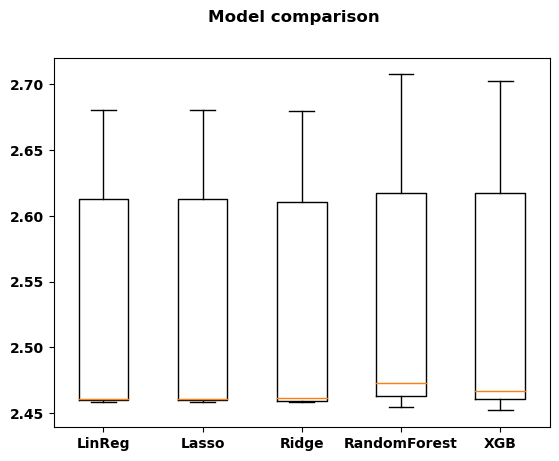

In [28]:
models = []

models.append(('LinReg', 'StandardScaler', LinearRegression()))
models.append(('Lasso', 'None', Lasso(alpha=0.0001)))
models.append(('Ridge', 'MinMax', Ridge(alpha=50)))
models.append(('RandomForest', 'None', RandomForestRegressor(max_depth=6, n_estimators=50)))
models.append(('XGB', 'MinMax', XGBRegressor(colsample_bytree=0.8,learning_rate=0.03,max_depth=6, min_child_weight=7)))

model_names, model_results = get_cv_scores(models, X_train, y_train)
compare_model_scores(model_names, model_results)

It seems that the optimized ridge regressor has the lowest RMSE score and lowest standard deviation between predictions of 2.53 and 0.093. 

Let's attempt to predict on the test set and check the predictions for the 22/23 season.

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

pipe = make_pipeline(MinMaxScaler(), Ridge(alpha=50))

pipe.fit(X_train, y_train)

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

print(f'Train R^2: {pipe.score(X_train, y_train)}\nTrain RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}\n\nTest R^2:{pipe.score(X_test, y_test)}\nTest RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')

Train R^2: 0.17932287168949268
Train RMSE: 2.5735189203148483

Test R^2:0.20587021401560934
Test RMSE: 2.3474365663885326


Our models test accuracy was better between the metrics of r-squared which helps to explain the variance of the data and RMSE which helps to explain how accurate our predictions are compared to the ground truth values. This ridge model achieved a r-squared score of 0.205 which is about 3% greater than the training accuracy. Additionally, the RMSE of the test data was 2.35 which is approximately 0.22 points better than the training accuracy.

Although this is a simpler model which only holds features of previous 5 gameweeks and a running tally between seasons, my previous attempt at modelling these points had a larger number of features and was only based on a subset of the 22/23 gameweek data. The RMSE score on the previous attempt was about 2.75, this model is not significantly better and therefore could still use more work in terms of feature selection/engineering and possibly creating separate models for each position may improve the accuracy.

<a id = 'fc'><h1> Future Considerations and Exporting </h1></a>

In the future it may beneficial to add opponent team names with label encoding to improve the RMSE of the model. If the opponent team is lower rated than the player may have a higher chance of earning more points in that game compared to a higher rated team. This may be reflected in the model with a label encoder since the FPL API has a different set of label encoding for team names each season it would be beneficial to unify the encoding by saving the team names in the dataframe and then label encoding all seasons at once. 

Another flaw in our model is that newly transferred players or upcoming stars do not have enough data to accurately predict their future performance therefore they are heavily overlooked by the model. 

For now let's see the results of the predicitions for the 22/23 season by exporting our results and selecting a team by gameweek in the following notebook!

In [30]:
pred_df = all_season_lagged.loc[all_season_lagged['season_x'] == '2022-23', ['name', 'team', 'position', 'GW', 'value', 'total_points']].reset_index(drop=True)
pred_df['pred'] = y_test_pred
pred_df.head()

,name,team,position,GW,value,total_points,pred
0,Nathan Redmond,Southampton,MID,6,53,0,0.485144
1,Junior Stanislas,Bournemouth,MID,6,48,0,0.465642
2,Armando Broja,Chelsea,FWD,6,54,1,0.692717
3,Fabian Schär,Newcastle,DEF,6,47,6,2.541648
4,Jonny Evans,Leicester,DEF,6,44,0,2.376991


In [31]:
pred_df.to_csv('../data/pred_2022_23.csv')